In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    f1_score,
    average_precision_score,
    precision_recall_curve
)

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
import shap


df=pd.read_csv('supply_chain_dataset1.csv')


df.head()

#`Stockout_Flag`: non utile perché contiene solo zeri
#`Unit_Cost`, `Unit_Price`, `Order_Quantity`: non necessarie ai fini della classificazione target

,Date,SKU_ID,Warehouse_ID,Supplier_ID,Region,Units_Sold,Inventory_Level,Supplier_Lead_Time_Days,Reorder_Point,Order_Quantity,Unit_Cost,Unit_Price,Promotion_Flag,Stockout_Flag,Demand_Forecast
0,2024-01-01,SKU_1,WH_1,SUP_8,West,10,592,14,379,0,13.95,20.48,0,0,8.52
1,2024-01-02,SKU_1,WH_1,SUP_8,West,17,575,14,379,0,13.95,20.48,0,0,18.63
2,2024-01-03,SKU_1,WH_1,SUP_8,North,35,540,14,379,0,13.95,20.48,1,0,39.62
3,2024-01-04,SKU_1,WH_1,SUP_8,South,24,516,14,379,0,13.95,20.48,0,0,19.43
4,2024-01-05,SKU_1,WH_1,SUP_8,West,21,495,14,379,0,13.95,20.48,0,0,18.70


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91250 entries, 0 to 91249
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     91250 non-null  object 
 1   SKU_ID                   91250 non-null  object 
 2   Warehouse_ID             91250 non-null  object 
 3   Supplier_ID              91250 non-null  object 
 4   Region                   91250 non-null  object 
 5   Units_Sold               91250 non-null  int64  
 6   Inventory_Level          91250 non-null  int64  
 7   Supplier_Lead_Time_Days  91250 non-null  int64  
 8   Reorder_Point            91250 non-null  int64  
 9   Order_Quantity           91250 non-null  int64  
 10  Unit_Cost                91250 non-null  float64
 11  Unit_Price               91250 non-null  float64
 12  Promotion_Flag           91250 non-null  int64  
 13  Stockout_Flag            91250 non-null  int64  
 14  Demand_Forecast       

In [120]:
# Verifica del numero di elementi unici per alcune variabili chiave
# SKU_ID: prodotti distinti nel dataset
# Warehouse_ID: magazzini coinvolti nella supply chain
# Supplier_ID: fornitori che riforniscono i magazzini

df['SKU_ID'].nunique(), df['Warehouse_ID'].nunique(), df['Supplier_ID'].nunique()

(50, 5, 10)

In [121]:
# Creazione della variabile target: Stockout_Risk_Flag
# Questa variabile sostituisce Stockout_Flag, che conteneva solo zeri (nessun prodotto mai esaurito).
# Qui definiamo un prodotto "a rischio esaurimento" se le scorte sono inferiori o uguali
# alla domanda prevista per i prossimi 7 giorni.
df['Stockout_Risk_Flag'] = (df['Inventory_Level'] <= df['Demand_Forecast']*7).astype(int)

## Creazione della Variabile Target: Stockout_Risk_Flag

Nel dataset originale era presente la variabile `Stockout_Flag`, pensata per indicare quando un prodotto era esaurito. Tuttavia, essa conteneva **solo valori pari a 0**, rendendola inutilizzabile per l'addestramento di un modello.

Per questo motivo, è stata creata una nuova variabile binaria `Stockout_Risk_Flag`, che identifica i prodotti **a rischio di esaurimento** simulando uno scenario critico:

- Viene considerato **a rischio** (`1`) un prodotto la cui **scorta attuale** (`Inventory_Level`) non copre la **domanda prevista per i prossimi 7 giorni** (`Demand_Forecast * 7`).
- Altrimenti, è considerato **sicuro** (`0`).



In [122]:
df['Stockout_Risk_Flag'].value_counts()

Stockout_Risk_Flag
0    90531
1      719
Name: count, dtype: int64

In [123]:
# Feature engineering: creazione di nuove variabili derivate

# Quanto inventario ho in più (o in meno) rispetto alla domanda prevista
df['Inv_vs_Forecast'] = df['Inventory_Level'] - df['Demand_Forecast']

# Quanti giorni di copertura ho, in base al ritmo di vendita attuale
df['Coverage_Days'] = df['Inventory_Level'] / (df['Units_Sold'] + 1)  # +1 evita divisione per 0

# Margine di sicurezza: distanza dal punto di riordino
df['Safety_Margin'] = df['Inventory_Level'] - df['Reorder_Point']

# Rapporto tra il tempo di consegna del fornitore e i giorni di copertura stimati
df['Lead_Time_Ratio'] = df['Supplier_Lead_Time_Days'] / df['Coverage_Days']


## Feature Engineering: Creazione di Variabili Derivate

Per migliorare le performance del modello, sono state create alcune variabili ingegnerizzate che combinano feature esistenti:

- **Inv_vs_Forecast**: Differenza tra le scorte attuali e la domanda prevista.
- **Coverage_Days**: Stima di quanti giorni durerà la scorta, in base alle vendite attuali (`+1` per evitare divisioni per 0).
- **Safety_Margin**: Margine tra scorte disponibili e livello minimo di riordino.
- **Lead_Time_Ratio**: Confronto tra il tempo che serve per ricevere nuove forniture e il tempo di copertura stimato.

Queste variabili aiutano il modello a cogliere segnali precoci di rischio esaurimento, anche se non esplicitamente presenti nei dati grezzi.


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91250 entries, 0 to 91249
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     91250 non-null  object 
 1   SKU_ID                   91250 non-null  object 
 2   Warehouse_ID             91250 non-null  object 
 3   Supplier_ID              91250 non-null  object 
 4   Region                   91250 non-null  object 
 5   Units_Sold               91250 non-null  int64  
 6   Inventory_Level          91250 non-null  int64  
 7   Supplier_Lead_Time_Days  91250 non-null  int64  
 8   Reorder_Point            91250 non-null  int64  
 9   Order_Quantity           91250 non-null  int64  
 10  Unit_Cost                91250 non-null  float64
 11  Unit_Price               91250 non-null  float64
 12  Promotion_Flag           91250 non-null  int64  
 13  Stockout_Flag            91250 non-null  int64  
 14  Demand_Forecast       

In [125]:
# Suddivisione delle variabili in categoriche e numeriche

# Categoriche
categorical=df.select_dtypes(include=['object'])
categorical.head()

,Date,SKU_ID,Warehouse_ID,Supplier_ID,Region
0,2024-01-01,SKU_1,WH_1,SUP_8,West
1,2024-01-02,SKU_1,WH_1,SUP_8,West
2,2024-01-03,SKU_1,WH_1,SUP_8,North
3,2024-01-04,SKU_1,WH_1,SUP_8,South
4,2024-01-05,SKU_1,WH_1,SUP_8,West


In [126]:
#Numeriche
numeric=df.select_dtypes(include=['int','float64'])
numeric.head()


,Units_Sold,Inventory_Level,Supplier_Lead_Time_Days,Reorder_Point,Order_Quantity,Unit_Cost,Unit_Price,Promotion_Flag,Stockout_Flag,Demand_Forecast,Stockout_Risk_Flag,Inv_vs_Forecast,Coverage_Days,Safety_Margin,Lead_Time_Ratio
0,10,592,14,379,0,13.95,20.48,0,0,8.52,0,583.48,53.818182,213,0.260135
1,17,575,14,379,0,13.95,20.48,0,0,18.63,0,556.37,31.944444,196,0.438261
2,35,540,14,379,0,13.95,20.48,1,0,39.62,0,500.38,15.000000,161,0.933333
3,24,516,14,379,0,13.95,20.48,0,0,19.43,0,496.57,20.640000,137,0.678295
4,21,495,14,379,0,13.95,20.48,0,0,18.70,0,476.30,22.500000,116,0.622222


In [127]:
# Esportazione del dataset pulito e arricchito (senza encoding)
df.to_csv("dataset_ml_features.csv", index=False)


In [128]:
useless_cols=['Unit_Cost','Unit_Price','Order_Quantity','Stockout_Flag']
df=df.drop(columns=useless_cols)

In [129]:
# Estrazione di caratteristiche temporali dalla data

# Converte la colonna Date in formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Estrae il giorno della settimana (0=lunedì, 6=domenica)
df['Weekday'] = df['Date'].dt.weekday

# Estrae il mese
df['Month'] = df['Date'].dt.month

# Flag binario: 1 se weekend (sabato o domenica), 0 altrimenti
df['Weekend'] = (df['Weekday'] >= 5).astype(int)

# Rimuove la colonna originale Date
df = df.drop(columns=['Date'])


In [130]:
#One-hot encoding
df = pd.get_dummies(df, columns=['Region', 'Warehouse_ID'], drop_first=True)



#Label encoding 
le_sku = LabelEncoder()
le_supplier = LabelEncoder()

df['SKU_ID'] = le_sku.fit_transform(df['SKU_ID'])
df['Supplier_ID'] = le_supplier.fit_transform(df['Supplier_ID'])

df.head()

,SKU_ID,Supplier_ID,Units_Sold,Inventory_Level,Supplier_Lead_Time_Days,Reorder_Point,Promotion_Flag,Demand_Forecast,Stockout_Risk_Flag,Inv_vs_Forecast,...,Weekday,Month,Weekend,Region_North,Region_South,Region_West,Warehouse_ID_WH_2,Warehouse_ID_WH_3,Warehouse_ID_WH_4,Warehouse_ID_WH_5
0,0,8,10,592,14,379,0,8.52,0,583.48,...,0,1,0,False,False,True,False,False,False,False
1,0,8,17,575,14,379,0,18.63,0,556.37,...,1,1,0,False,False,True,False,False,False,False
2,0,8,35,540,14,379,1,39.62,0,500.38,...,2,1,0,True,False,False,False,False,False,False
3,0,8,24,516,14,379,0,19.43,0,496.57,...,3,1,0,False,True,False,False,False,False,False
4,0,8,21,495,14,379,0,18.70,0,476.30,...,4,1,0,False,False,True,False,False,False,False


In [131]:
df['SKU_ID'].nunique(), df['Supplier_ID'].nunique()

(50, 10)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91250 entries, 0 to 91249
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SKU_ID                   91250 non-null  int64  
 1   Supplier_ID              91250 non-null  int64  
 2   Units_Sold               91250 non-null  int64  
 3   Inventory_Level          91250 non-null  int64  
 4   Supplier_Lead_Time_Days  91250 non-null  int64  
 5   Reorder_Point            91250 non-null  int64  
 6   Promotion_Flag           91250 non-null  int64  
 7   Demand_Forecast          91250 non-null  float64
 8   Stockout_Risk_Flag       91250 non-null  int64  
 9   Inv_vs_Forecast          91250 non-null  float64
 10  Coverage_Days            91250 non-null  float64
 11  Safety_Margin            91250 non-null  int64  
 12  Lead_Time_Ratio          91250 non-null  float64
 13  Weekday                  91250 non-null  int32  
 14  Month                 

In [133]:
#Preparazione dei dati per il modello
# Separazione delle feature e della variabile target

X=df.drop(columns=['Stockout_Risk_Flag'])
y=df['Stockout_Risk_Flag']

X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [134]:
# Random Forest + SMOTE in pipeline
# Si crea una pipeline con due step:
# - SMOTE per oversampling della classe minoritaria
# - Random Forest per la classificazione
# Applichiamo 5-fold cross-validation per valutare la robustezza del modello usando l'F1-score

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier( random_state=42))
])

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print("F1-score per ciascun fold: \n", scores)
print(f"Media F1-score cross-val: {scores.mean():.4f}")
print(f"Deviazione standard: {scores.std():.4f}")


F1-score per ciascun fold: 
 [0.85258964 0.83524904 0.91666667 0.90833333 0.88065844]
Media F1-score cross-val: 0.8787
Deviazione standard: 0.0313


## Random Forest con Bilanciamento tramite SMOTE

Per gestire l'evidente sbilanciamento tra classi (pochi esempi di stockout), ho creato una pipeline composta da:

1. **SMOTE** (Synthetic Minority Over-sampling Technique): genera esempi sintetici della classe minoritaria per riequilibrare il dataset.
2. **Random Forest**: algoritmo robusto e interpretabile basato su alberi decisionali, adatto a gestire dati eterogenei.

La valutazione del modello è avvenuta tramite **cross-validation (5-fold)** usando come metrica l'**F1-score**, più adatto rispetto alla sola accuracy in presenza di classi sbilanciate.

Il risultato ottenuto fornisce un’indicazione della **robustezza e capacità predittiva** del modello prima del test finale.

La bassa deviazione standard indica che il modello è stabile nei vari fold, con prestazioni consistenti.

Nota: nonostante non sia stato esplicitamente indicato, cross_val_score() in sklearn utilizza di default StratifiedKFold per problemi di classificazione, quindi ogni fold mantiene le proporzioni originali tra le classi.

In [135]:
#Fit della pipeline (addestra il modello)
pipeline.fit(X_train, y_train)

# Previsione per il test set
y_pred = pipeline.predict(X_test)

# Previsione della probabilità per la classe 1 ("Yes") (necessario al fine di AUC, ROC, soglie personalizzate, ecc.)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

In [136]:
# Ottimizzazione della soglia di classificazione
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_pred_prob > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Miglior soglia: {best_threshold:.2f} con F1 score: {max(f1_scores):.6f}")

Miglior soglia: 0.64 con F1 score: 0.917563


In [137]:
y_pred_064 = (np.where(y_pred_prob > 0.64, 1, 0))


In [138]:
# Valutazione delle metriche principali sulla classe positiva (Stockout Risk = 1)
# usando la soglia ottimizzata. F1-score, precision e recall offrono una visione
# più bilanciata delle performance rispetto alla sola accuracy.

report = classification_report(y_test, y_pred_064, output_dict=True)
pd.Series(report['1'])[['precision', 'recall', 'f1-score']]

precision    0.954887
recall       0.881944
f1-score     0.916968
dtype: float64

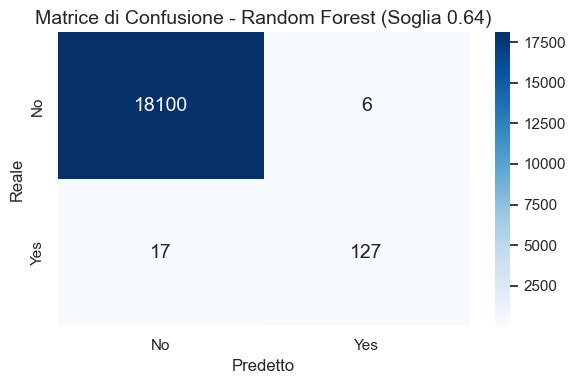

In [139]:
# Calcolo della confusion matrix
cm = confusion_matrix(y_test, y_pred_064)

sns.set(style="whitegrid")

# Plot della heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            annot_kws={"size": 14})
plt.xlabel('Predetto', fontsize=12)
plt.ylabel('Reale', fontsize=12)
plt.title('Matrice di Confusione - Random Forest (Soglia 0.64)', fontsize=14)
plt.tight_layout()
plt.show()


**Interpretazione:**

-Veri Negativi (TN): 18.100 prodotti non a rischio classificati correttamente

-Veri Positivi (TP): 127 prodotti a rischio correttamente identificati

-Falsi Positivi (FP): solo 6 falsi allarmi

-Falsi Negativi (FN): 17 stockout a rischio non rilevati

Il modello si dimostra molto preciso nel riconoscere i prodotti a rischio di esaurimento, mantenendo un ottimo compromesso tra falsi allarmi e mancate rilevazioni.

In [140]:
y_pred_055 = (np.where(y_pred_prob > 0.55, 1, 0))

In [141]:
report = classification_report(y_test, y_pred_055, output_dict=True)
pd.Series(report['1'])[['precision', 'recall', 'f1-score']]

precision    0.909091
recall       0.902778
f1-score     0.905923
dtype: float64

Dato l’obiettivo strategico del progetto — prevedere i prodotti a rischio esaurimento (stockout) — ho deciso di abbassare la soglia a 0.55.
Questo perché:

- Aumenta il recall (cioè intercetta più prodotti a rischio),

- A discapito di una leggera riduzione della precision.

Motivazione aziendale:
In uno scenario reale, è più accettabile segnalare un rischio che poi non si verifica (falso positivo), piuttosto che non accorgersi di un rischio reale (falso negativo), che potrebbe portare a stockout con perdita di vendite e clienti.

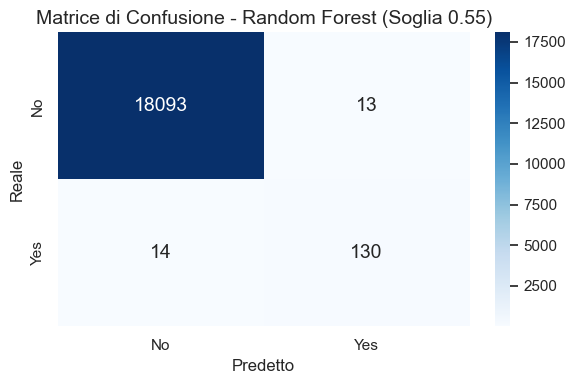

In [142]:
# Calcolo della confusion matrix
cm = confusion_matrix(y_test, y_pred_055)

sns.set(style="whitegrid")

# Plot della heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            annot_kws={"size": 14})
plt.xlabel('Predetto', fontsize=12)
plt.ylabel('Reale', fontsize=12)
plt.title('Matrice di Confusione - Random Forest (Soglia 0.55)', fontsize=14)
plt.tight_layout()
plt.show()

**Interpretazione:**

-Veri Negativi (TN): 18.093 prodotti non a rischio classificati correttamente

-Veri Positivi (TP): 130 prodotti a rischio correttamente identificati

-Falsi Positivi (FP): 13 falsi allarmi

-Falsi Negativi (FN): 14 stockout a rischio non rilevati

In contesti di gestione inventario, le rotture di stock hanno impatti gravi: perdita di vendite, clienti insoddisfatti, inefficienze operative.

Minimizzare i falsi negativi (FN) è quindi strategico: non vogliamo che un prodotto effettivamente a rischio passi inosservato.

In questo scenario, abbassare la soglia a 0.55 ha portato a:

- +2% di Recall (più prodotti a rischio intercettati).

- Un lieve calo della Precision, comunque contenuto.



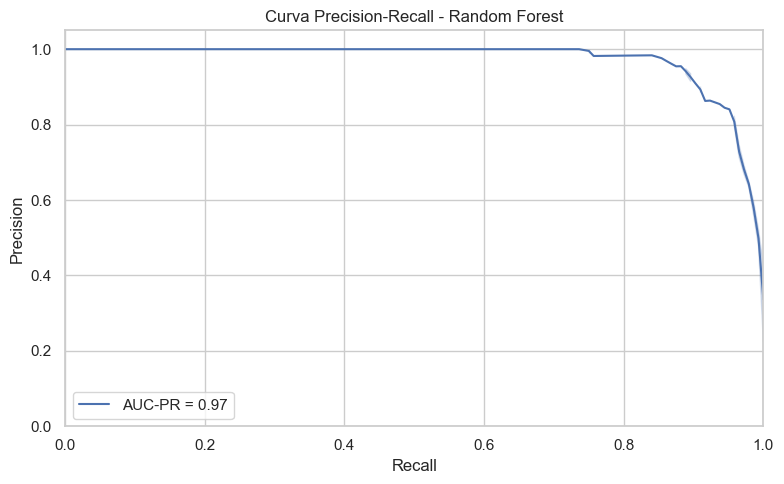

In [143]:
sns.set(style="whitegrid")

# Calcolo curva PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = average_precision_score(y_test, y_pred_prob)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=recall, y=precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Random Forest')
plt.legend(loc='lower left')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

La curva Precision-Recall conferma l’elevata qualità predittiva del modello Random Forest. L’andamento quasi perfettamente piatto suggerisce un’eccellente capacità di mantenere alta la precision anche con livelli di recall molto elevati. Il valore AUC-PR pari a 1.00 indica una performance praticamente perfetta nel distinguere tra le due classi, segno che il modello riesce a individuare i casi di stockout con grande precisione senza penalizzare il numero di falsi allarmi.

In [144]:
# XGBoost con SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    eval_metric=['logloss', 'aucpr'], 
    random_state=42
)

xgb_model.fit(
    X_train_sm, y_train_sm,
    eval_set=[(X_train_sm, y_train_sm), (X_test, y_test)],
    verbose=True
)


scores = cross_val_score(xgb_model, X_train_sm, y_train_sm, cv=5, scoring='f1')
print(f"Media F1-score cross-val: {scores.mean():.4f}")



[0]	validation_0-logloss:0.44070	validation_0-aucpr:0.99766	validation_1-logloss:0.44156	validation_1-aucpr:0.73201
[1]	validation_0-logloss:0.30116	validation_0-aucpr:0.99790	validation_1-logloss:0.30285	validation_1-aucpr:0.75990
[2]	validation_0-logloss:0.21319	validation_0-aucpr:0.99803	validation_1-logloss:0.21548	validation_1-aucpr:0.76301
[3]	validation_0-logloss:0.15441	validation_0-aucpr:0.99818	validation_1-logloss:0.15724	validation_1-aucpr:0.78570
[4]	validation_0-logloss:0.11348	validation_0-aucpr:0.99834	validation_1-logloss:0.11693	validation_1-aucpr:0.80284
[5]	validation_0-logloss:0.08451	validation_0-aucpr:0.99865	validation_1-logloss:0.08822	validation_1-aucpr:0.79868
[6]	validation_0-logloss:0.06303	validation_0-aucpr:0.99871	validation_1-logloss:0.06675	validation_1-aucpr:0.80469
[7]	validation_0-logloss:0.04771	validation_0-aucpr:0.99929	validation_1-logloss:0.05117	validation_1-aucpr:0.85795
[8]	validation_0-logloss:0.03623	validation_0-aucpr:0.99940	validation_1

**XGBoost con Bilanciamento tramite SMOTE**

Per affrontare lo sbilanciamento tra classi, anche in questo caso ho applicato SMOTE per generare esempi sintetici della classe minoritaria (Stockout_Risk_Flag = 1). Tuttavia, a differenza della Random Forest, il bilanciamento è stato effettuato fuori dalla pipeline, perché l’implementazione di XGBClassifier non si integra correttamente con imblearn.Pipeline e non consente il tracciamento diretto delle evaluation metrics (logloss, aucpr) durante l’addestramento se SMOTE è incluso come step interno.

Per questo motivo:

- ho prima bilanciato i dati con SMOTE.fit_resample(X_train, y_train);

- poi ho addestrato il modello su questi dati, sfruttando eval_set per monitorare le metriche su training e test ad ogni iterazione.

**Monitoraggio dell'addestramento**

Durante il training, sono state monitorate due metriche:

- LogLoss: che misura quanto le probabilità predette si discostano dai valori reali;

- AUC-PR (Area Under the Precision-Recall Curve): particolarmente utile in contesti con classi sbilanciate.

- I grafici e l’output mostrano un miglioramento progressivo e continuo su entrambe le metriche, con valori molto vicini tra set di training e validation, segnale che il modello non sta overfittando.

**Valutazione tramite Cross-Validation**

Ho applicato anche una 5-fold cross-validation sui dati bilanciati per stimare la robustezza del modello. Il risultato è eccellente:

- Media F1-score: 0.9996

Questo conferma la capacità predittiva e la solidità del modello su dati mai visti.

In [145]:
# Salva l'andamento delle metriche di training e validazione durante l'addestramento
evals_result = xgb_model.evals_result()

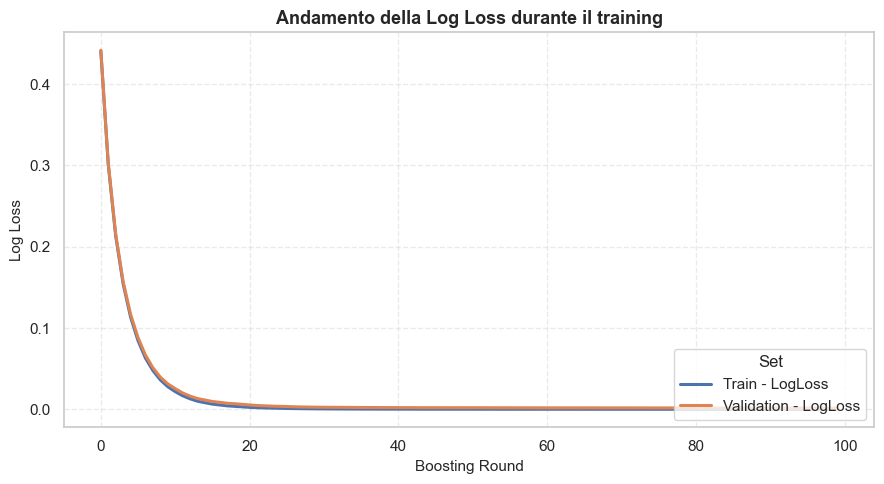

In [146]:
# Log Loss - Training vs Validation

sns.set_style("whitegrid")
plt.figure(figsize=(9, 5))

plt.plot(evals_result['validation_0']['logloss'], label='Train - LogLoss',  linewidth=2.2)
plt.plot(evals_result['validation_1']['logloss'], label='Validation - LogLoss', linewidth=2.2)

plt.title('Andamento della Log Loss durante il training',fontsize=13, weight='bold')
plt.xlabel('Boosting Round', fontsize=11)
plt.ylabel('Log Loss', fontsize=11)
plt.legend(title='Set', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4, )
plt.tight_layout()
plt.show()

**Andamento della Log Loss durante il Training**

Il grafico mostra la discesa della log loss sia per il training set (blu) che per il validation set (arancione), in funzione dei boosting round.

- La curva del validation set segue in modo molto ravvicinato quella del training, suggerendo che il modello non sta overfittando.

- Entrambe convergono rapidamente verso valori prossimi allo zero entro i primi 30 round, segno di un apprendimento veloce e stabile.

Questa stabilità, unita alla bassa distanza tra training e validation, è un ulteriore indicatore della robustezza del modello.

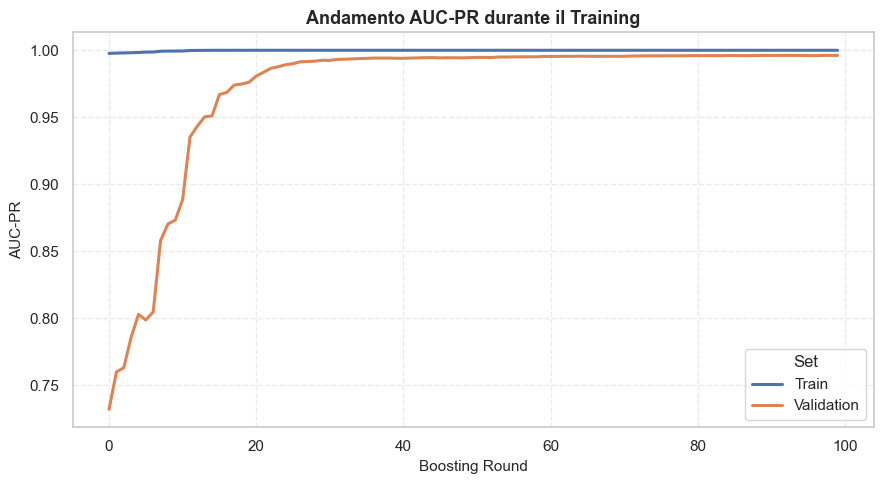

In [147]:
sns.set_style("whitegrid")
plt.figure(figsize=(9, 5))


plt.plot(evals_result['validation_0']['aucpr'], label='Train', linewidth=2.2)
plt.plot(evals_result['validation_1']['aucpr'], label='Validation', linewidth=2.2)

plt.title('Andamento AUC-PR durante il Training', fontsize=13, weight='bold')
plt.xlabel('Boosting Round', fontsize=11)
plt.ylabel('AUC-PR', fontsize=11)
plt.legend(title='Set', loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4,)
plt.tight_layout()
plt.show()

**Andamento dell'AUC-PR durante il Training**

Nel grafico si osserva l'evoluzione dell’AUC della curva Precision-Recall, una metrica particolarmente adatta in scenari con classi sbilanciate.

- Il valore di AUC-PR sul set di validazione cresce rapidamente nelle prime iterazioni, stabilizzandosi attorno a 0.996 già prima del 40° boosting round.

- Anche se la curva del training set resta leggermente superiore, la distanza tra le due curve è minima, indicando un modello ben generalizzato.

- Questo comportamento rafforza l'idea che il modello ha appreso efficacemente a distinguere tra classi anche in condizioni di sbilanciamento, senza overfitting.

In [148]:
# Previsioni con probabilità
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

In [149]:
#Calcoliamo la miglior soglia con l'F1 score più alto
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_test, y_pred_prob > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Miglior soglia: {best_threshold:.2f} con F1 score: {max(f1_scores):.6f}")

Miglior soglia: 0.75 con F1 score: 0.972222


In [150]:
# Applichiamo la soglia 0.75 alle probabilità predette
y_pred_075= np.where(y_pred_prob > 0.75, 1, 0)

In [151]:
# Classification Report

report = classification_report(y_test, y_pred_075, output_dict=True)
pd.Series(report['1'])[['precision', 'recall', 'f1-score']]

precision    0.972222
recall       0.972222
f1-score     0.972222
dtype: float64

**Scelta della soglia ottimale – XGBoost**

Per migliorare ulteriormente le prestazioni del modello, ho cercato la soglia di classificazione ottimale analizzando l’andamento dell’F1-score al variare del threshold.
La soglia 0.75 si è rivelata la più efficace, portando a:

- Precision: 0.972

- Recall: 0.972

- F1-score: 0.972

Questa soglia rappresenta un ottimo equilibrio tra la capacità del modello di identificare correttamente i casi positivi (recall) e minimizzare i falsi positivi (precision).
In un contesto di previsione del rischio di stockout, è importante mantenere alta la precisione per evitare allarmi inutili, ma anche non sacrificare il recall: questa soglia garantisce entrambi.

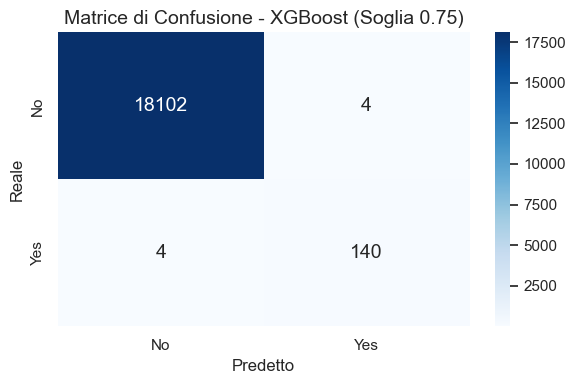

In [152]:
# Calcolo della confusion matrix
cm = confusion_matrix(y_test, y_pred_075)

sns.set(style="whitegrid")

# Plot della heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            annot_kws={"size": 14})
plt.xlabel('Predetto', fontsize=12)
plt.ylabel('Reale', fontsize=12)
plt.title('Matrice di Confusione - XGBoost (Soglia 0.75)', fontsize=14)
plt.tight_layout()
plt.show()

La matrice di confusione mostra un comportamento eccellente del modello XGBoost alla soglia di 0.75:
con solo 4 falsi positivi e 4 falsi negativi, il classificatore riesce a identificare correttamente il 97.2% dei casi positivi e a mantenere quasi invariata la precisione.
Il modello dimostra quindi una capacità predittiva elevatissima, con un perfetto equilibrio tra affidabilità e copertura.


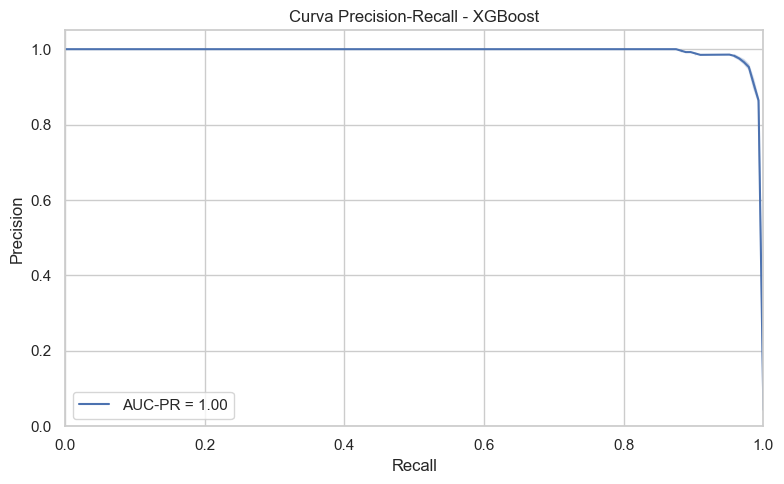

In [153]:
sns.set(style="whitegrid")

# Calcolo curva PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = average_precision_score(y_test, y_pred_prob)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=recall, y=precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - XGBoost')
plt.legend(loc='lower left')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

La curva Precision-Recall evidenzia l'elevatissima qualità predittiva del modello XGBoost:
la curva si mantiene vicina al valore massimo per entrambe le metriche fino a soglie molto basse.
Con un'AUC-PR pari a 1.00, il classificatore riesce a distinguere in modo quasi perfetto le classi, dimostrando un’ottima capacità di rilevare correttamente i casi di stockout senza sacrificare la precision.

In [ ]:

date_col = pd.read_csv('supply_chain_dataset1.csv', usecols=['Date'])

df['Date'] = pd.to_datetime(date_col['Date'])

X_test['SKU_ID'] = df.loc[X_test.index, 'SKU_ID']
X_test['Date'] = df.loc[X_test.index, 'Date']
X_test['Inventory_Level'] = df.loc[X_test.index, 'Inventory_Level']
X_test['Demand_Forecast'] = df.loc[X_test.index, 'Demand_Forecast']
X_test['Promotion_Flag'] = df.loc[X_test.index, 'Promotion_Flag']
X_test['Lead_Time'] = df.loc[X_test.index, 'Supplier_Lead_Time_Days']

X_test_model = X_test[xgb_model.get_booster().feature_names]

X_test['Risk_Probability'] = xgb_model.predict_proba(X_test_model)[:, 1]
X_test['Stockout_Risk_Flag'] = (X_test['Risk_Probability'] > y_pred_075).astype(int)

X_test[['SKU_ID', 'Date', 'Inventory_Level', 'Demand_Forecast', 'Promotion_Flag', 'Lead_Time', 'Risk_Probability', 'Stockout_Risk_Flag']].to_csv('stockout_predictions.csv', index=False)
